<a href="https://colab.research.google.com/github/imji0319/new_python/blob/master/DACON/Arctic/shardcode.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [DACON COMP : 북극 해빙 농도 예측 AI](https://dacon.io/competitions/official/235706/overview/) 





In [2]:
!pip install -q git+http://github.com/tensorflow/examples.git
!pip install -q tensorflow-addons

     |████████████████████████████████| 706kB 6.6MB/s 


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from pathlib import Path

import datetime
import os 
import time
from tqdm import tqdm

import tensorflow as tf
from tensorflow_examples.models.pix2pix import pix2pix

In [3]:
print(f'tf.__version__ : {tf.__version__}')

tf.__version__ : 2.4.1


In [4]:
gpus = tf.config.list_physical_devices("GPU")

if gpus:
    try : 

        for gpu in gpus :
            tf.config.experimental.set_memory_growth(gpu, True)

        logical_gpus = tf.config.experimental.list_logical_devices("GPU")
        print(f"{len(gpus)} Physical GPUs, {len(logical_gpus)} Logical GPUs")

    except RuntimeError as e:
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [5]:
!nvidia-smi

Thu Mar  4 04:12:38 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    23W /  75W |    199MiB /  7611MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [6]:
!free -h

              total        used        free      shared  buff/cache   available
Mem:            12G        1.1G        9.1G        9.0M        2.5G         11G
Swap:            0B          0B          0B


In [7]:
## HyperParameters 설정 

class HParams(object):
    
    def __init__(self):

        # Path 
        self.cwd = Path('/content/drive/MyDrive/Colab/dacon-Arctic')
        self.data = self.cwd/ Path("data")
        self.tr_data = self.data / Path('train')
        self.tr_npy = self.data / Path('train.npy')
        self.ts_npy = self.data / Path('test.npy')

        self.sample_submission = self.data / Path('sample_submission.csv')
        self.mask = self.data/ Path('mask.npy')

        self.submission_path = self.cwd/ Path("submission")

        # Pole Patch 
        self.pole_large_idx = np.arange(0,105,1)
        self.pole_medium_idx = np.arange(106,349,1)
        self.pole_small_idx = np.arange(350,482,1)


        # train & test split 
        self.num_test = 48
        self.val_size = 0.25 


        # Dataset Pieline 
        self.w_inp = 4
        self.w_tar = 2
        self.w_sft = 1
        self.w_std = 12 ## every year
        self.w_dr = True 


        self.buffer_sz = 1_000
        self.auto = tf.data.experimental.AUTOTUNE
        self.global_batch_sz = 8 

        # Modeling 
        self.backbone = tf.keras.applications.MobileNetV2

        self.image_sz = [448, 304]
        self.resized_image_sz = [int(np.ceil(i/ 2**5) * 2 ** 5 ) for i in self.image_sz] ## [448, 320]


        # Fit 
        self.epoch = 50

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
HPARAMS = HParams()

## Preprocess 
이미지 & 마스킹 크기 : [ 448, 304 ] => [448 , 320]   
* MoblieNetV2 내부에서는 5번의 Squeeze (Conv2D@stride = 2) 작업이 존재하여 입력값이 가로/세로 크기가 32(2*5)의 배수가 되지 않으면 원래 사이즈로 Decoding 되지 않기 때문.  



In [10]:
# Load Numpy Files 

tot_filenames = sorted(list(HPARAMS.tr_data.glob("*")))
tot_filenames[:10]

[PosixPath('/content/drive/MyDrive/Colab/dacon-Arctic/data/train/197811.npy'),
 PosixPath('/content/drive/MyDrive/Colab/dacon-Arctic/data/train/197812.npy'),
 PosixPath('/content/drive/MyDrive/Colab/dacon-Arctic/data/train/197901.npy'),
 PosixPath('/content/drive/MyDrive/Colab/dacon-Arctic/data/train/197902.npy'),
 PosixPath('/content/drive/MyDrive/Colab/dacon-Arctic/data/train/197903.npy'),
 PosixPath('/content/drive/MyDrive/Colab/dacon-Arctic/data/train/197904.npy'),
 PosixPath('/content/drive/MyDrive/Colab/dacon-Arctic/data/train/197905.npy'),
 PosixPath('/content/drive/MyDrive/Colab/dacon-Arctic/data/train/197906.npy'),
 PosixPath('/content/drive/MyDrive/Colab/dacon-Arctic/data/train/197907.npy'),
 PosixPath('/content/drive/MyDrive/Colab/dacon-Arctic/data/train/197908.npy')]

In [11]:
tot = []

for filename in tqdm(tot_filenames):
    tot.append(
        np.load(filename))
    
tot = np.array(tot)
print(f'tot shape : {tot.shape}')

100%|██████████| 482/482 [02:03<00:00,  3.89it/s]


tot shape : (482, 448, 304, 5)


## Add zero paddings 

In [12]:
padded_tot = np.zeros((tot.shape[0], *HPARAMS.resized_image_sz, tot.shape[3]), 
                      dtype =np.uint8)

padded_tot[...,3] = 1

padded_tot[:tot.shape[0], :tot.shape[1], :tot.shape[2], :tot.shape[3]] = tot

In [13]:
padded_tot.shape

(482, 448, 320, 5)

In [14]:
## concat two masks 
padded_tot[...,3] += padded_tot[...,2]


tr_npy = padded_tot[:-HPARAMS.num_test, ...,[0,3]]
ts_npy = padded_tot[-HPARAMS.num_test:, ..., [0,3]]

print(f'train npy shape {tr_npy.shape}')
print(f'test npy shape {ts_npy.shape}')

train npy shape (434, 448, 320, 2)
test npy shape (48, 448, 320, 2)


In [74]:
# tr_npy 와 ts_npy 을 npy파일로 저장 
np.save(HPARAMS.tr_npy, tr_npy)
np.save(HPARAMS.ts_npy, ts_npy)

In [76]:
!apt-get install tree

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  tree
0 upgraded, 1 newly installed, 0 to remove and 29 not upgraded.
Need to get 40.7 kB of archives.
After this operation, 105 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tree amd64 1.7.0-5 [40.7 kB]
Fetched 40.7 kB in 1s (49.9 kB/s)
Selecting previously unselected package tree.
(Reading database ... 160975 files and directories currently installed.)
Preparing to unpack .../tree_1.7.0-5_amd64.deb ...
Unpacking tree (1.7.0-5) ...
Setting up tree (1.7.0-5) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...


In [78]:
!tree -L 2 $HPARAMS.cwd

/content/drive/MyDrive/Colab/dacon-Arctic
├── data
│   ├── sample_submission.csv
│   ├── test.npy
│   ├── train
│   ├── train.csv
│   └── train.npy
└── shardcode.ipynb

2 directories, 5 files


## Make DataSet Pipeline

input window sequence : 4개      
output window sequence : 2개 

## Load Preprocessed Numpy File

In [15]:
tr_npy  = np.load(HPARAMS.tr_npy)
ts_npy = np.load(HPARAMS.ts_npy)

In [16]:
split_len = int(tr_npy.shape[0] * HPARAMS.val_size) # train : 75%, validation : 25% 
vl_npy = tr_npy[-split_len:]
tr_npy = tr_npy[:-split_len]

print(f'train npy shape : {tr_npy.shape}')
print(f'validation npy shape : {vl_npy.shape}')
print(f'test npy shape : {ts_npy.shape}')

train npy shape : (326, 448, 320, 2)
validation npy shape : (108, 448, 320, 2)
test npy shape : (48, 448, 320, 2)


## build Dataset

In [17]:
@tf.function
def flat_fn_tr(x):
    return x.batch(HPARAMS.w_inp + HPARAMS.w_tar)


@tf.function
def flat_fn_ts(x):
    return x.batch(HPARAMS.w_inp)

@tf.function
def split_mask(x):
    return tf.split(x,[1,1], axis = -1) ## keep dims 


@tf.function
def rescaling(images, masks):
    return (tf.cast(images, dtype = tf.dtypes.float32)/ 250. , 
            tf.cast(masks[:,0], tf.dtypes.float32))
    

@tf.function
def split_window(images, masks):
    inp,tar = tf.split(images, [HPARAMS.w_inp, HPARAMS.w_tar], axis = 1 )

    return (inp, masks), tar

In [18]:
# Numpy to tensor 

tr_tensor = tf.constant(tr_npy)
vl_tensor = tf.constant(vl_npy)
ts_tensor = tf.constant(ts_npy)

In [19]:
tr_tensor.shape

TensorShape([326, 448, 320, 2])

In [20]:
####  Make dataset Pipeline 

# train dataset 

tr_ds = tf.data.Dataset.from_tensor_slices(tr_tensor
                        ).window(HPARAMS.w_inp + HPARAMS.w_tar, HPARAMS.w_sft, HPARAMS.w_std, HPARAMS.w_dr
                        ).flat_map(flat_fn_tr
                        ).shuffle(HPARAMS.buffer_sz
                        ).batch(HPARAMS.global_batch_sz
                        ).map(split_mask, num_parallel_calls = HPARAMS.auto
                        ).map(rescaling, num_parallel_calls = HPARAMS.auto
                        #).map(split_images, num_parallel_calls = HPARAMS.auto).unbatch(
                        ).map(split_window, num_parallel_calls = HPARAMS.auto
                        ).prefetch(HPARAMS.auto)

# validation dataset 
vl_ds = tf.data.Dataset.from_tensor_slices(vl_tensor
                        ).window(HPARAMS.w_inp + HPARAMS.w_tar, HPARAMS.w_sft,  HPARAMS.w_std, HPARAMS.w_dr
                        ).flat_map(flat_fn_tr
                        #).shuffle(HPARAMS.buffer_sz
                        ).batch(HPARAMS.global_batch_sz
                        ).map(split_mask, num_parallel_calls = HPARAMS.auto
                        ).map(rescaling, num_parallel_calls = HPARAMS.auto
                        #).map(split_images, num_parallel_calls = HPARAMS.auto).unbatch(
                        ).map(split_window, num_parallel_calls = HPARAMS.auto
                        ).prefetch(HPARAMS.auto)


# test dataset 
ts_ds = tf.data.Dataset.from_tensor_slices(ts_tensor
                        ).window(HPARAMS.w_inp , HPARAMS.w_sft,  HPARAMS.w_std, HPARAMS.w_dr
                        ).flat_map(flat_fn_tr
                        #).shuffle(HPARAMS.buffer_sz
                        ).batch(HPARAMS.global_batch_sz
                        ).map(split_mask, num_parallel_calls = HPARAMS.auto
                        ).map(rescaling, num_parallel_calls = HPARAMS.auto
                        #).map(split_images, num_parallel_calls = HPARAMS.auto).unbatch(
                        #).map(split_window, num_parallel_calls = HPARAMS.auto
                        ).prefetch(HPARAMS.auto)

In [21]:
print(f'tr_ds.element_spec : {tr_ds.element_spec}')
print(f'vl_ds.element_spec : {vl_ds.element_spec}')
print(f'ts_ds.element_spec : {ts_ds.element_spec}')

tr_ds.element_spec : ((TensorSpec(shape=(None, 4, 448, 320, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 448, 320, 1), dtype=tf.float32, name=None)), TensorSpec(shape=(None, 2, 448, 320, 1), dtype=tf.float32, name=None))
vl_ds.element_spec : ((TensorSpec(shape=(None, 4, 448, 320, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 448, 320, 1), dtype=tf.float32, name=None)), TensorSpec(shape=(None, 2, 448, 320, 1), dtype=tf.float32, name=None))
ts_ds.element_spec : (TensorSpec(shape=(None, None, 448, 320, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 448, 320, 1), dtype=tf.float32, name=None))


In [105]:
len(list(tr_ds.unbatch().as_numpy_iterator()))

266

In [106]:
len(list(vl_ds.unbatch().as_numpy_iterator()))

48

In [107]:
len(list(ts_ds.unbatch().as_numpy_iterator()))

12

In [22]:
for ele in tr_ds.take(1):
    (foo, bar), qux = ele

    print(foo.shape, bar.shape, qux.shape)

(8, 4, 448, 320, 1) (8, 448, 320, 1) (8, 2, 448, 320, 1)


# Create Network

- MobileNetV2 
- 자기회귀모델 구조 인용 

In [23]:
# Backbone 모델 : MobileNetV2

def Backbone():
    m = HPARAMS.backbone(input_shape = (*HPARAMS.resized_image_sz, 3), # MobileNetV2
                         include_top = False,
                         weights= None) 
    
    layer_names = ['block_1_expand_relu',
                   'block_3_expand_relu',
                   'block_6_expand_relu',
                   'block_13_expand_relu',
                   'block_16_project']


    return tf.keras.Model(inputs = m.input, 
                          outputs = [m.get_layer(name).output for name in layer_names])

In [24]:
# Encoder 

class Encoder(tf.keras.Model):
    def __init__(self):
        super(Encoder, self).__init__()

        self.backbone = Backbone()


    def call(self, x, return_skips = True):
        if x.shape[-1] == 1:
            x = tf.tile(x, [1,1,1,3])

        xs = self.backbone(x)
        if return_skips :
            return xs[-1], xs[:-1]

        else: 
            return xs[-1]

In [25]:
# Decoder 

class Decoder(tf.keras.Model):
    def __init__(self):
        super(Decoder, self).__init__()

        self.ups = [pix2pix.upsample(256,4, apply_dropout = True),
                    pix2pix.upsample(128,4, apply_dropout = True),
                    pix2pix.upsample(64,4),
                    pix2pix.upsample(32,4)]

        
        self.convT = tf.keras.layers.Conv2DTranspose(32,3, strides = 2, padding = "same")
        self.bn = tf.keras.layers.BatchNormalization()
        self.relu = tf.keras.layers.ReLU()
        self.conv2d = tf.keras.layers.Conv2D(1, 1, activation ='sigmoid')

    

    def call(self, x, skips ):

        for up in self.ups:
            x = up(x)
            x = tf.keras.layers.Concatenate()([x, skips.pop()])


        x = self.convT(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.conv2d(x)

        return x 

In [26]:
# UNet Model 

class UnetModel(tf.keras.Model):
    def __init__(self, name):
        super(UnetModel, self).__init__(name = name)

        self.encoder = Encoder()
        self.decoder = Decoder()
        self.convlstm = tf.keras.layers.ConvLSTM2D(256, 3, padding ='same',
                                                   return_state = True, recurrent_dropout = 0.4)
        
        self.out_steps = HPARAMS.w_tar

    def warmup(self, x, skips):
        x, *state = self.convlstm(x)
        prediction = self.decoder(x, skips)

        return prediction, state 

    def call(self, inputs, training  = None ):

        x, masks = inputs 
        masks = tf.tile(tf.expand_dims(masks, axis = 1),
                        [1, self.out_steps, 1, 1, 1])
        
        predictions = []

        _, skips = self.encoder(x[:, -1])

        x = tf.stack([self.encoder(sub_x, return_skips = False) 
                                    for sub_x in tf.unstack(x, axis =1)], axis =1 )
        
        # warmup the convlstm
        prediction, state = self.warmup(x, skips )
        predictions.append(prediction)

        for _ in range(1, self.out_steps):
            x, skips = self.encoder(prediction)
            x, *state = self.convlstm(tf.expand_dims(x, axis = 1),
                                      initial_state = state, 
                                      training = training)
            
            prediciton = self.decoder(x, skips)
            predictions.append(prediction)


        return tf.stack(predictions, axis = 1)*(1.-masks)

## Define Loss function and Metrics

In [157]:
@tf.function
def mae_score(y_true, y_pred):
    return tf.math.reduce_mean(tf.math.abs(y_true - y_pred))



@tf.function
def f1_score(y_true, y_pred, lower_bound = 0.05, upper_bound = 0.5, threshold = 0.5, epsilon = 1e-8):

    y_true = tf.where(y_true > upper_bound, 0., y_true)
    y_true = tf.where(y_true < lower_bound, 0., y_true)
    y_pred = tf.where(y_pred > upper_bound, 0., y_pred)
    y_pred = tf.where(y_pred < lower_bound, 0., y_pred)

    y_true = tf.where(y_true < 0.15, 0., 1)
    y_pred = tf.where(y_pred < 0.15, 0., 1)

    tp = tf.math.reduce_sum(tf.where(y_true*y_pred == 1., 1., 0.))

    precision = tp / (tf.math.reduce_sum(y_true) + epsilon)
    recall = tp / (tf.math.reduce_sum(y_pred) + epsilon)

    return 2 * precision * recall / (precision + recall + epsilon)


@tf.function
def mae_over_f1(y_true, y_pred, epsilon = 1e-8):
    return tf.math.divide_no_nan(mae_score(y_true, y_pred),
                                 f1_score(y_true, y_pred) + epsilon)

## Fit the Network 

In [27]:
def get_callbacks(model_name):

    ckpt_path = f"/content/drive/MyDrive/Colab/dacon-Arctic/ckpt/{model_name}/"+"cp-{epoch:03d}-{val_loss:.4f}.ckpt"
    os.makedirs(os.path.dirname(ckpt_path), exist_ok= True)

    cp_callback = tf.keras.callbacks.ModelCheckpoint(ckpt_path, verbose = 0,
                                                     monitor = 'val_loss', save_weight_only = True, 
                                                     save_best_only = True)
    
    log_dir = f'/content/drive/MyDrive/Colab/dacon-Arctic/logs/fit/{model_name}'
    tb_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir, histogram_freq=1)

    return [cp_callback, tb_callback]


In [159]:
model_name = datetime.datetime.now().strftime('%Y%m%d-%H%M%S')

model  = UnetModel(name = model_name)

In [163]:
model.compile(optimizer='adam',
              loss = mae_over_f1,
              metrics = [mae_score, f1_score])

In [164]:
start = time.time()
_ = model.fit(tr_ds, 
              validation_data = vl_ds,
              epochs = HPARAMS.epoch,
              verbose = 2,
              callbacks = get_callbacks(model.name))
sec = time.time() - start 

Epoch 1/50
34/34 - 98s - loss: 0.1767 - mae_score: 0.0415 - f1_score: 0.2442 - val_loss: 10544693.0000 - val_mae_score: 0.1054 - val_f1_score: 0.0000e+00
Epoch 2/50
34/34 - 67s - loss: 0.0922 - mae_score: 0.0266 - f1_score: 0.2941 - val_loss: 10223832.0000 - val_mae_score: 0.1022 - val_f1_score: 0.0000e+00
Epoch 3/50
34/34 - 68s - loss: 0.0729 - mae_score: 0.0228 - f1_score: 0.3164 - val_loss: 10156468.0000 - val_mae_score: 0.1016 - val_f1_score: 0.0000e+00
Epoch 4/50
34/34 - 67s - loss: 0.0638 - mae_score: 0.0207 - f1_score: 0.3240 - val_loss: 10097735.0000 - val_mae_score: 0.1010 - val_f1_score: 0.0000e+00
Epoch 5/50
34/34 - 68s - loss: 0.0555 - mae_score: 0.0188 - f1_score: 0.3423 - val_loss: 10079295.0000 - val_mae_score: 0.1008 - val_f1_score: 0.0000e+00
Epoch 6/50
34/34 - 67s - loss: 0.0494 - mae_score: 0.0178 - f1_score: 0.3588 - val_loss: 10060815.0000 - val_mae_score: 0.1006 - val_f1_score: 0.0000e+00
Epoch 7/50
34/34 - 67s - loss: 0.0472 - mae_score: 0.0173 - f1_score: 0.3674

In [146]:
tr_ds.element_spec

((TensorSpec(shape=(None, 4, 448, 320, 1), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 448, 320, 1), dtype=tf.float32, name=None)),
 TensorSpec(shape=(None, 2, 448, 320, 1), dtype=tf.float32, name=None))

# Predict

In [33]:
def load_latest_checkpoint(ckpt_folder):
    latest = tf.train.latest_checkpoint(ckpt_folder)
    print(f'load latest Checkpoint : {latest} ...')


    model = UnetModel(name = f"{ckpt_folder.split('/')[-1]}-latest")
    ckpt = tf.train.Checkpoint(model)
    ckpt.restore(latest).expect_partial()

    print(f"Restored model : {model.name}")

    return model

In [35]:
ckpt_folder = f'/content/drive/MyDrive/Colab/dacon-Arctic/ckpt/20210303-142255'

latest_model = load_latest_checkpoint(ckpt_folder)

load latest Checkpoint : /content/drive/MyDrive/Colab/dacon-Arctic/ckpt/20210303-142255/cp-044-0.0401.ckpt ...
Restored model : 20210303-142255-latest


In [36]:
result = []

for element in ts_ds:
    result.append(latest_model.predict(element))

result = np.concatenate(result, axis = 0)
result = np.reshape(result, 
                    (result.shape[0]* result.shape[1], *result.shape[2:]))

print(f'result.shape : {result.shape}')


result.shape : (24, 448, 320, 1)


In [37]:
rebuild_image = result[:, :HPARAMS.image_sz[0], : HPARAMS.image_sz[1]]
rebuild_image = np.clip(rebuild_image, 0, 1) * 250 
rebuild_image = rebuild_image.astype(np.uint8)

print(f'rebuild_image.shape : {rebuild_image.shape}', \
      f'rebuild_image.dtype : {rebuild_image.dtype}')

rebuild_image.shape : (24, 448, 304, 1) rebuild_image.dtype : uint8


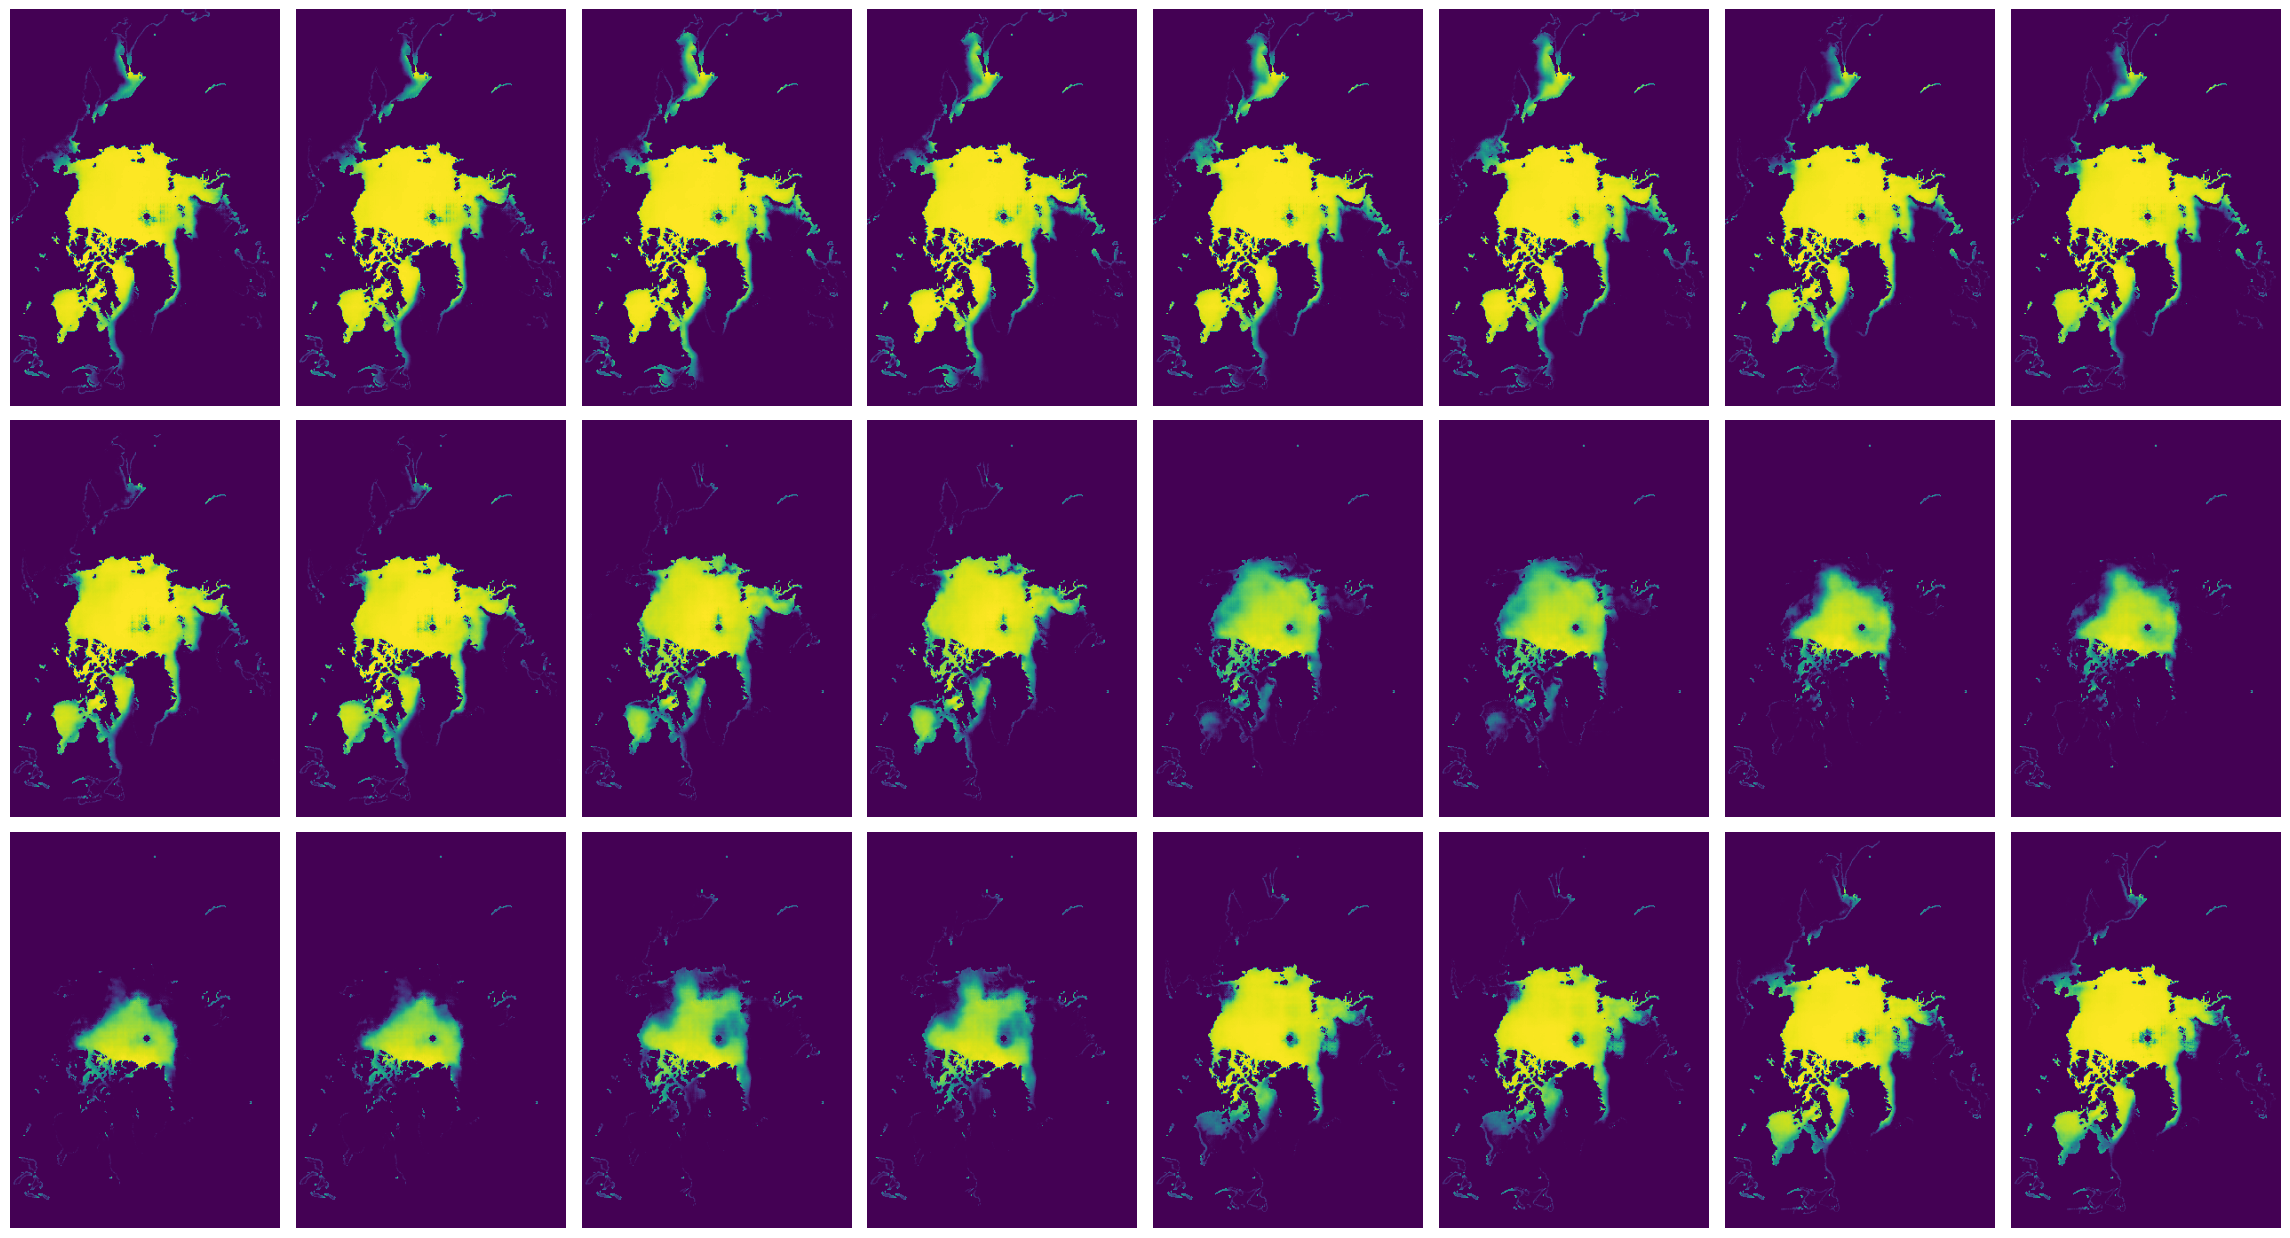

In [38]:
plt.figure(figsize = ( 24,13), facecolor= "white", dpi = 96 )

for i, img in enumerate(rebuild_image):
    plt.subplot(3,8, i+ 1)
    plt.imshow(img[...,0])

    plt.axis("off")

plt.tight_layout()
plt.show()

## Make Submission 
예측값을 reshaping 

In [39]:
submission = pd.read_csv(HPARAMS.sample_submission, index_col = 0 )
submission.shape

(24, 136192)

In [40]:
submission.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,136152,136153,136154,136155,136156,136157,136158,136159,136160,136161,136162,136163,136164,136165,136166,136167,136168,136169,136170,136171,136172,136173,136174,136175,136176,136177,136178,136179,136180,136181,136182,136183,136184,136185,136186,136187,136188,136189,136190,136191
month,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-01,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2019-02,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2019-03,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2019-04,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2019-05,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [41]:
%%time 

submission.iloc[:,:] = np.reshape(rebuild_image, 
                                  (rebuild_image.shape[0], -1 ))
submission.head()

CPU times: user 9.17 ms, sys: 116 µs, total: 9.28 ms
Wall time: 17.9 ms


In [42]:
submission.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,136152,136153,136154,136155,136156,136157,136158,136159,136160,136161,136162,136163,136164,136165,136166,136167,136168,136169,136170,136171,136172,136173,136174,136175,136176,136177,136178,136179,136180,136181,136182,136183,136184,136185,136186,136187,136188,136189,136190,136191
month,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-01,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2019-02,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2019-03,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2019-04,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2019-05,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [44]:
HPARAMS.submission_path.mkdir(exist_ok=True)
file_path = HPARAMS.submission_path /Path(f'{latest_model.name}.csv')
submission.to_csv(file_path)